# Buck

Assume a buck converter as shown below.

![](../media/l7_buck.svg)

Assume we don't know what's happening inside the Control block. We assume that switch A is never on at the same time as B. How does the output voltage evolve with time?

The output voltage will be an integral of the current $I_x$ and $I_o$

$$V_o = \frac{1}{C} \int{(I_x - I_o)}dt$$

The current through the inductor will be an integral of the voltage across the inductor.

$$I_x = \frac{1}{L} \int{V_x dt}$$

The differential equations are not necessarily that easy to solve. Most of the state variables (V_o,V_x,I_x) are non-linear as a function of time.

I figured that instead of trying the differential equations by hand, we can solve them numerically in Python.

First, some constants, and let's assume A and B are periodic. When A is on, B is off, when B is on, A is off. We can model the A on time by a duty-cycle of the period.

In [1]:
import numpy as np

mode=""
#mode="start"
mode="settled"

u = 1e-6                        # A micro unit
L = 1 * u                       # 1 uH
Rs = 1                          # Resistance in switches
C = 1 * u                       # 1 uF
R = 100                         # Load resistor
T = 0.1 * u                     # Period of A/B
dtc = 0.25                      # Duty-cycle A
VDDH = 4.0                      # VDD voltage
VO_initial = 0                  # Initial output voltage
N = 2**15                       # Number of samples
t_end = 10e-6                   # Time to simulate

if mode=="settled":
    t_end = 15e-6                   

if mode=="start":
    t_end = 0.25e-6

To simulate what happens we need the state variables and time vector

In [2]:
t = np.linspace(0,t_end,N)      # Time vector
vo = np.ones(N)*VO_initial      # Output voltage
ix = np.zeros(N)                # Current in inductor
vx = np.zeros(N)                # Voltage across inductor
v1 = np.zeros(N)                # Voltage at left side of inductor
io = np.zeros(N)                # Current drawn from output
ivdd = np.zeros(N)              # Current drawn from VDD
a = np.zeros(N)

I then loop across time, and figure out what happens.

In [3]:
for i in range(1,N):
    ts = t[i] 

    # Model switch
    if(ts % T < dtc*T):
        pmos = 1
        a[i] = 1
    else:
        pmos = 0
        

    # Delta time
    dt = (t[i]-t[i-1])

    # Current voltage across the inductor
    vx[i] = pmos*(VDDH) - Rs*ix[i-1] -vo[i-1]

    # Current in inductor, use trapezoidal approximation of area
    ix[i] = ix[i-1] + 1/L * (vx[i] + vx[i-1])/2*dt 

    if(pmos):
        ivdd[i] = ix[i]

    # Output current
    io[i] = 1/R * vo[i-1]

    # Output voltage
    vo[i] = vo[i-1] + 1/C * ( (ix[i] + ix[i-1])/2 - (io[i] + io[i-1])/2)*dt


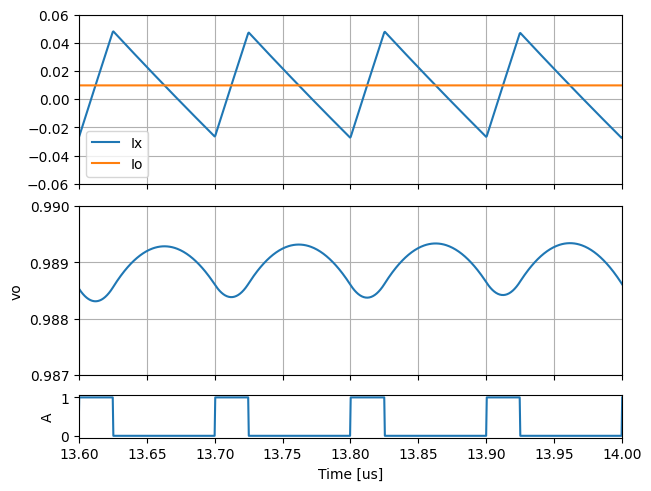

In [4]:
import matplotlib.pyplot as plt
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, ncols=1, constrained_layout=True,sharex=True,gridspec_kw={'height_ratios':[4,4,1]})

ax0.plot(t/u,ix,label="Ix")
ax0.plot(t/u,io,label="Io")
ax0.legend()
ax0.grid('both')
plt.xlabel("Time [us]")
ax1.grid('both')
ax1.plot(t/u,vo)
ax1.set_ylabel("vo")
ax2.plot(t/u,a)
plt.ylabel("A")

if mode=="settled":
    ax0.set_ylim(-0.06,0.06)
    ax1.set_ylim(0.987,0.990)
    plt.xlim(13.6,14)


plt.xlabel("Time [us]")
plt.savefig(f"../media/l07_buck_pwm_fig_{mode}.pdf")

In [5]:
vo_avg = np.mean(vo[int(N/2):])
ix_avg = np.mean(ix[int(N/2):])
io_avg = np.mean(io[int(N/2):])
ivdd_avg = np.mean(ivdd[int(N/2):])
pwr_vdd = ivdd_avg*VDDH
pwr_vo = vo_avg*io_avg
efficiency = pwr_vo/pwr_vdd*100
m = 1e-3
print("Output voltage =  %.4g mV" % (vo_avg/m))
print("Inductor current = %.4g mA" % (ix_avg/m))
print("Load current = %.4g mA" % (io_avg/m))
print("VDDH current = %.4g mA" % (ivdd_avg/m))
print("VDDH Power = %.4g mW" % (pwr_vdd/m))
print("VO Power = %.4g mW" % (pwr_vo/m))
print("Efficiency = %.4g pct" % (efficiency))


Output voltage =  987.6 mV
Inductor current = 13.27 mA
Load current = 9.876 mA
VDDH current = 3.44 mA
VDDH Power = 13.76 mW
VO Power = 9.753 mW
Efficiency = 70.88 pct


## What happens when I change the duty cycle?

The output voltage will stabilize at approximately $ V_o = V_{DDH} \times D_{tc}$

## What happens to the output voltage when I change the load current?

Not much. The output voltage drops due to the series resistance in the switches $V_o = V_{DDH} D_{tc} -  R_s I_o $ 

## What happens if the initial output voltage is zero?
We can observe a huge overshoot in the inductor current (Amps). These high currents can kill our device.

## Can I make output voltage independent of input voltage?

Yes. With a feedback loop. If I measure the error in $V_o$ and adjust $D_{tc}$ accordingly, then I can control the output voltage even if the input voltage changes.